<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_VectorQuantized_single_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Neural Discrete Representation Learning: https://arxiv.org/abs/1711.00937  
Generating Diverse High-Fidelity Images with VQ-VAE-2: https://arxiv.org/abs/1906.00446

VQ-VAE example: https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [1]:
!pip install scanpy

In [2]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix

import h5py
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import keras.backend as K

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [3]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

W0711 20:28:28.296665 139794663720832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0711 20:28:28.985511 139794663720832 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Create some data

In [0]:
def import_data_fn(string):
    data_mat = h5py.File(string)
    x_data = np.array(data_mat['X'])
    y_data = np.array(data_mat['Y'])
    return x_data, y_data, np.where(x_data > 0.0, 1, 0)

In [5]:
X_1, y_1, Z_1 = import_data_fn('10X_PBMC.h5')
print(X_1.shape)
# X_2, y_2, Z_2 = import_data_fn('mouse_bladder_cell.h5')
# print(X_2.shape)
# X_3, y_3, Z_3 = import_data_fn('worm_neuron_cell.h5')
# X_3, y_3, Z_3 = np.delete(X_3, 2682, axis=0), np.delete(y_3, 2682, axis=0), np.delete(Z_3, 2682, axis=0)
# print(X_3.shape)

(4271, 16653)


NameError: ignored

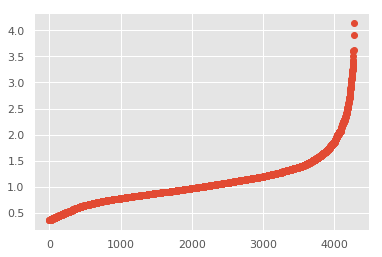

In [6]:
plt.plot(np.sort(np.mean(X_1, axis=1)/np.median(np.mean(X_1, axis=1))), 'o');
plt.plot(np.sort(np.mean(X_2, axis=1)/np.median(np.mean(X_2, axis=1))), 'o');
plt.plot(np.sort(np.mean(X_3, axis=1)/np.median(np.mean(X_3, axis=1))), 'o');
plt.xlabel('cells');
plt.ylabel('mean over genes/median');
plt.legend(('pbmc', 'bladder', 'neuron'))

NameError: ignored

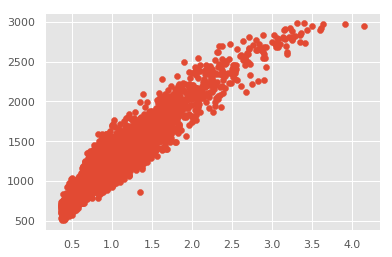

In [7]:
plt.scatter(np.mean(X_1, axis=1)/np.median(np.mean(X_1, axis=1)), np.sum(Z_1, axis=1))
plt.scatter(np.mean(X_2, axis=1)/np.median(np.mean(X_2, axis=1)), np.sum(Z_2, axis=1))
plt.scatter(np.mean(X_3, axis=1)/np.median(np.mean(X_3, axis=1)), np.sum(Z_3, axis=1))
plt.xlabel('mean over genes/median')
plt.ylabel('sum of non-zero genes')
plt.legend(('pbmc', 'bladder', 'neuron'))

In [8]:
p1 = []
pn1 = []
for i in range(50):
  lim = i
  pn1.append(lim)
  n = Z_1.shape[1]-np.argwhere(np.sum(Z_1, axis=0)>lim).shape[0]
  p1.append(n)

p2 = []
pn2 = []
for i in range(50):
  lim = i
  pn2.append(lim)
  n = Z_2.shape[1]-np.argwhere(np.sum(Z_2, axis=0)>lim).shape[0]
  p2.append(n)  
  
p3 = []
pn3 = []
for i in range(50):
  lim = i
  pn3.append(lim)
  n = Z_3.shape[1]-np.argwhere(np.sum(Z_3, axis=0)>lim).shape[0]
  p3.append(n) 

NameError: ignored

ValueError: ignored

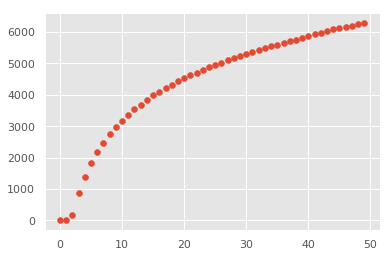

In [9]:
plt.scatter(pn1, p1);
plt.scatter(pn2, p2);
plt.scatter(pn3, p3);
plt.xlabel('n cells');
plt.ylabel('number of genes with n cells or less');
plt.legend(('pbmc', 'bladder', 'neuron'))

In [0]:
def remove_genes(X, Z, n):
  indx = np.argwhere(np.sum(Z, axis=0)>n)
  X1 = np.squeeze(X[:, indx])
  Z1 = np.squeeze(Z[:, indx])
  return X1, Z1

In [11]:
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)

(4271, 16653)


NameError: ignored

In [12]:
X_1, Z_1 = remove_genes(X_1, Z_1, 5)
X_2, Z_2 = remove_genes(X_2, Z_2, 5)
X_3, Z_3 = remove_genes(X_3, Z_3, 5)

NameError: ignored

In [13]:
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)

(4271, 14835)


NameError: ignored

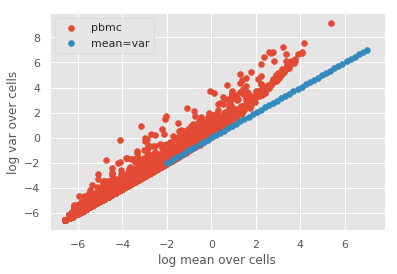

In [14]:
xp = np.linspace(-2,7)
plt.scatter(np.log(np.mean(X_1, axis=0)), np.log(np.var(X_1, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('pbmc', 'mean=var'));

In [15]:
xp = np.linspace(-2,4)
plt.scatter(np.log(np.mean(X_2, axis=0)), np.log(np.var(X_2, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('bladder', 'mean=var'));

NameError: ignored

In [16]:
xp = np.linspace(-3,2)
plt.scatter(np.log(np.mean(X_3, axis=0)), np.log(np.var(X_3, axis=0)));
plt.scatter(xp, xp);
plt.xlabel('log mean over cells');
plt.ylabel('log var over cells');
plt.legend(('neuron', 'mean=var'));

NameError: ignored

In [0]:
def adjust(X, do):
  if do:
    return (X-np.mean(X, axis=0))/np.std(X, axis=0)
  else:
    return X

In [18]:
s_1 = np.sum(X_1, axis=1)
s_2 = np.sum(X_2, axis=1)
s_3 = np.sum(X_3, axis=1)

NameError: ignored

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(64)(x)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(32)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(16)(h)
    h = tf.nn.leaky_relu(h)
    h = tf.layers.dense(h, 16, activation=tf.nn.leaky_relu)
    h = snt.Linear(16)(h)
    h = tf.reshape(h, shape=(-1, 2))
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = tf.reshape(x, shape=(-1, 16))
    h = snt.Linear(16)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(32)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(64)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(self.output_dim, use_bias=False)(h)
    h = tf.clip_by_value(tf.math.softplus(h), 1e-5, 1e6)
    return h

# Build Graph and train

In [20]:
X_1.shape

(4271, 14835)

In [0]:
randc = np.random.choice(X_1.shape[0], size=500, replace=False)
X = X_1[randc, :]
s = s_1[randc]
s = s.reshape(-1,1)

In [100]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 128

num_training_updates = 40000
embedding_dim = 2
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 100

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25/1000.0

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 9e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices((X, X, s))
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x_in = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
x_out = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
s_mult = tf.placeholder(tf.float32, shape=(None, 1))

z = encoder(x_in)
# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
x_recon = s_mult*x_recon

recon_error = -tf.reduce_mean(tfd.Poisson(rate=x_recon).log_prob(x_out))
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  a, b, c = get_samples(sess)
  feed_dict = {x_in: a, x_out: b, s_mult: c}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 500 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-200:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-200:]))
    print()


500 iterations
recon_error: 1.009
perplexity: 12.644

1000 iterations
recon_error: 0.927
perplexity: 16.373

1500 iterations
recon_error: 0.777
perplexity: 17.136

2000 iterations
recon_error: 0.745
perplexity: 17.222

2500 iterations
recon_error: 0.700
perplexity: 16.962

3000 iterations
recon_error: 0.587
perplexity: 16.139

3500 iterations
recon_error: 0.568
perplexity: 16.612

4000 iterations
recon_error: 0.551
perplexity: 15.842

4500 iterations
recon_error: 0.537
perplexity: 15.529

5000 iterations
recon_error: 0.531
perplexity: 15.250

5500 iterations
recon_error: 0.522
perplexity: 18.788

6000 iterations
recon_error: 0.518
perplexity: 20.524

6500 iterations
recon_error: 0.512
perplexity: 22.698

7000 iterations
recon_error: 0.509
perplexity: 25.453

7500 iterations
recon_error: 0.507
perplexity: 27.349

8000 iterations
recon_error: 0.506
perplexity: 29.762

8500 iterations
recon_error: 0.504
perplexity: 30.979

9000 iterations
recon_error: 0.504
perplexity: 31.154

9500 iterat

KeyboardInterrupt: ignored

# Plot loss

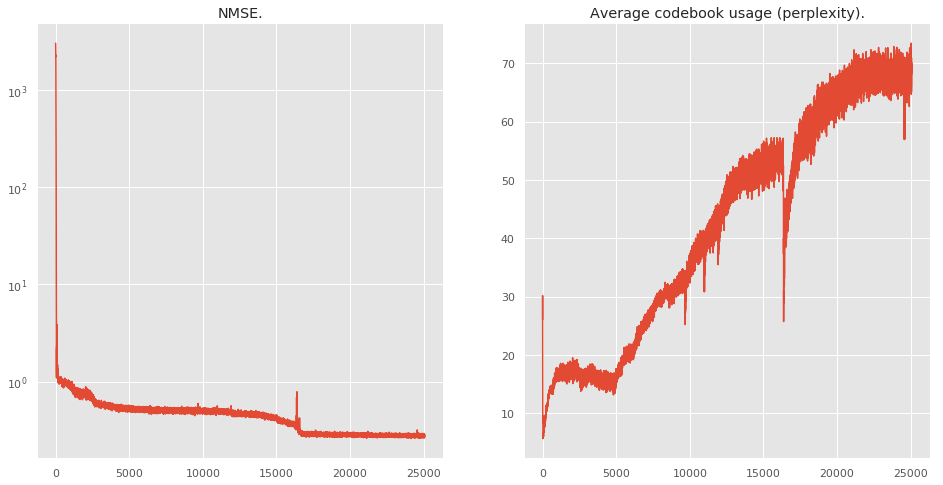

In [101]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).');

# View latent space

In [0]:
# Latent space
z_, vq_output_eval_, x_recon_, z_d_  = sess.run([z, vq_output_eval, x_recon, vq_output_train["quantize"]], feed_dict={x_in: X, x_out: X, s_mult: s})

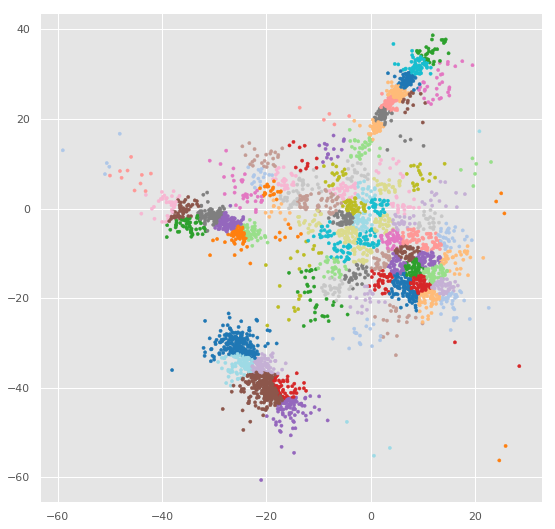

In [106]:
plt.figure(figsize=(9,9))
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'], cmap='tab20', s=10.0);
#plt.scatter(z_d_[:,0], z_d_[:,1], c='red', s=20.0);

In [107]:
y_1[randc]

array([4, 1, 1, 5, 5, 4, 2, 1, 1, 1, 2, 2, 6, 7, 1, 4, 1, 3, 1, 1, 1, 5,
       7, 2, 5, 3, 1, 7, 1, 1, 4, 3, 4, 4, 2, 7, 3, 2, 7, 4, 1, 2, 4, 1,
       5, 1, 2, 1, 1, 8, 5, 3, 1, 6, 6, 5, 1, 1, 2, 2, 1, 7, 4, 2, 4, 1,
       5, 4, 7, 2, 5, 2, 1, 3, 7, 1, 2, 5, 1, 6, 1, 3, 5, 1, 8, 5, 8, 7,
       1, 3, 2, 1, 1, 3, 2, 2, 7, 1, 5, 7, 7, 3, 5, 7, 1, 5, 2, 2, 1, 2,
       1, 2, 6, 1, 6, 4, 1, 1, 7, 4, 7, 7, 1, 4, 2, 4, 4, 7, 1, 5, 5, 3,
       2, 5, 2, 7, 1, 3, 1, 2, 5, 3, 1, 5, 2, 1, 1, 1, 1, 7, 2, 2, 6, 1,
       6, 2, 3, 4, 1, 1, 2, 5, 3, 1, 4, 2, 5, 1, 6, 7, 5, 1, 4, 1, 1, 1,
       1, 1, 1, 3, 3, 2, 5, 1, 2, 2, 2, 1, 3, 1, 6, 3, 3, 8, 6, 5, 1, 1,
       3, 1, 5, 8, 4, 7, 7, 3, 7, 5, 2, 2, 2, 2, 1, 1, 6, 1, 4, 1, 1, 2,
       3, 4, 5, 7, 1, 6, 2, 3, 1, 1, 2, 1, 2, 5, 6, 1, 1, 1, 1, 1, 6, 1,
       1, 2, 1, 1, 6, 4, 5, 8, 2, 1, 1, 6, 1, 2, 1, 1, 2, 3, 5, 2, 2, 7,
       7, 5, 7, 2, 4, 5, 3, 4, 3, 2, 7, 1, 8, 3, 3, 5, 6, 6, 2, 4, 7, 1,
       2, 3, 2, 7, 2, 2, 7, 2, 1, 6, 1, 2, 8, 3, 6,

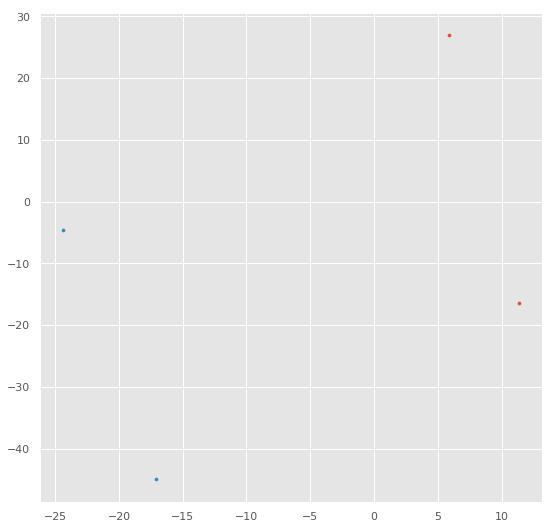

In [115]:
plt.figure(figsize=(9,9))
plt.scatter(z_[0:2,0], z_[0:2,1], cmap='tab20', s=10.0);
plt.scatter(z_[X.shape[0]:X.shape[0]+2,0], z_[X.shape[0]:X.shape[0]+2,1], cmap='tab20', s=10.0);
# plt.scatter(z_[X.shape[0]:2*X.shape[0],0], z_[X.shape[0]:2*X.shape[0],1], c=y_1[randc], cmap='tab20', s=10.0);
# plt.scatter(z_[2*X.shape[0]:3*X.shape[0],0], z_[2*X.shape[0]:3*X.shape[0],1], c=y_1[randc], cmap='tab20', s=10.0);
# plt.scatter(z_[3*X.shape[0]:4*X.shape[0],0], z_[3*X.shape[0]:4*X.shape[0],1], c=y_1[randc], cmap='tab20', s=10.0);